### PREPROCESSING AND VISUALIZATION

In [1]:
import os
import numpy as np 
import pandas as pd 
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import style
from pandas import DataFrame,merge
style.use("ggplot")
%matplotlib inline

import xgboost as xgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier , VotingClassifier
from sklearn.svm import SVC

##### Read Data

In [2]:
dftrain = pd.read_csv('data/train.csv', header=0, sep=',', quotechar='"')
dftrain.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [3]:
dftest = pd.read_csv('data/test.csv', header=0, sep=',', quotechar='"')
dftest.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### PREPROCESSING

##### Train Data preprocessing

In [4]:
animals_train = deepcopy(dftrain)

del animals_train['OutcomeSubtype']
# del animals_train['AnimalID']

In [5]:
animals_train = animals_train[['AnimalID', 'Name', 'DateTime', 'AnimalType','SexuponOutcome', 'AgeuponOutcome', 'Breed', 
                               'Color', 'OutcomeType']]

In [6]:
animals_train.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Return_to_owner
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Euthanasia
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Adoption
3,A683430,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Transfer
4,A667013,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Transfer


In [7]:
len(animals_train)

26729

In [8]:
animals_test = deepcopy(dftest)

# del animals_test['ID']
animals_test.rename(columns={'ID': 'AnimalID'}, inplace=True)
animals_test['OutcomeType'] = 'Unknown'

In [9]:
animals_test = animals_test[['AnimalID', 'Name', 'DateTime', 'AnimalType','SexuponOutcome', 'AgeuponOutcome', 'Breed', 
                             'Color', 'OutcomeType']]

In [10]:
animals_test.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,Unknown
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,Unknown
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,Unknown
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,Unknown
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,Unknown


In [11]:
len(animals_test)

11456

In [12]:
animals = animals_train.append(animals_test)

In [13]:
animals.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Return_to_owner
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Euthanasia
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Adoption
3,A683430,NaN,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Transfer
4,A667013,NaN,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Transfer


In [14]:
len(animals)

38185

##### NaN values

In [15]:
print("")
print('Total length of full dataset:', len(animals))
print('NaN AnimalType:', len(animals)-len(animals[animals['AnimalType'].notna()]))
print('NaN SexuponOutcome:', len(animals)-len(animals[animals['SexuponOutcome'].notna()]))
print('NaN AgeuponOutcome:', len(animals)-len(animals[animals['AgeuponOutcome'].notna()]))
print('NaN Breed:', len(animals)-len(animals[animals['Breed'].notna()]))
print('NaN Color:', len(animals)-len(animals[animals['Color'].notna()]))
print('NaN DateTime:', len(animals)-len(animals[animals['DateTime'].notna()]))
print('NaN Name:', len(animals)-len(animals[animals['Name'].notna()]))

print("")
print('Total length of train dataset:', len(animals_train))
print('NaN AnimalType:', len(animals_train)-len(animals_train[animals_train['AnimalType'].notna()]))
print('NaN SexuponOutcome:', len(animals_train)-len(animals_train[animals_train['SexuponOutcome'].notna()]))
print('NaN AgeuponOutcome:', len(animals_train)-len(animals_train[animals_train['AgeuponOutcome'].notna()]))
print('NaN Breed:', len(animals_train)-len(animals_train[animals_train['Breed'].notna()]))
print('NaN Color:', len(animals_train)-len(animals_train[animals_train['Color'].notna()]))
print('NaN DateTime:', len(animals_train)-len(animals_train[animals_train['DateTime'].notna()]))
print('NaN Name:', len(animals_train)-len(animals_train[animals_train['Name'].notna()]))

print("")
print('Total length of test dataset:', len(animals_test))
print('NaN AnimalType:', len(animals_test)-len(animals_test[animals_test['AnimalType'].notna()]))
print('NaN SexuponOutcome:', len(animals_test)-len(animals_test[animals_test['SexuponOutcome'].notna()]))
print('NaN AgeuponOutcome:', len(animals_test)-len(animals_test[animals_test['AgeuponOutcome'].notna()]))
print('NaN Breed:', len(animals_test)-len(animals_test[animals_test['Breed'].notna()]))
print('NaN Color:', len(animals_test)-len(animals_test[animals_test['Color'].notna()]))
print('NaN DateTime:', len(animals_test)-len(animals_test[animals_test['DateTime'].notna()]))
print('NaN Name:', len(animals_test)-len(animals_test[animals_test['Name'].notna()]))


Total length of full dataset: 38185
NaN AnimalType: 0
NaN SexuponOutcome: 1
NaN AgeuponOutcome: 24
NaN Breed: 0
NaN Color: 0
NaN DateTime: 0
NaN Name: 10916

Total length of train dataset: 26729
NaN AnimalType: 0
NaN SexuponOutcome: 1
NaN AgeuponOutcome: 18
NaN Breed: 0
NaN Color: 0
NaN DateTime: 0
NaN Name: 7691

Total length of test dataset: 11456
NaN AnimalType: 0
NaN SexuponOutcome: 0
NaN AgeuponOutcome: 6
NaN Breed: 0
NaN Color: 0
NaN DateTime: 0
NaN Name: 3225


##### Unique values

In [16]:
print('Unique AnimalType:', len(animals["AnimalType"].unique()))
print('Unique SexuponOutcome:', len(animals["SexuponOutcome"].unique()))
print('Unique AgeuponOutcome:', len(animals["AgeuponOutcome"].unique()))
print('Unique Breed:', len(animals["Breed"].unique()))
print('Unique Color:', len(animals["Color"].unique()))
print('Unique Name:', len(animals["Name"].unique()))

Unique AnimalType: 2
Unique SexuponOutcome: 6
Unique AgeuponOutcome: 46
Unique Breed: 1678
Unique Color: 411
Unique Name: 7969


##### SexuponOutcome column preprocessing

In [19]:
# Μissing sex value for one animal in train dataset

# find most popular sex
animals.SexuponOutcome.mode() # it is Neutered Male
# replace
animals['SexuponOutcome'].fillna('Neutered Male', inplace=True)

# check 
print('NaN SexuponOutcome:', len(animals)-len(animals[animals['SexuponOutcome'].notna()]))

NaN SexuponOutcome: 0


##### Name column preprocessing

In [21]:
animals['NameBinary'] = animals['Name'].apply(lambda x: 1 if not pd.isnull(x) else 0)

print('NaN NameBinary:', len(animals)-len(animals[animals['NameBinary'].notna()]))
print('Unique NameBinary:', len(animals["NameBinary"].unique()), animals["NameBinary"].unique())

NaN NameBinary: 0
Unique NameBinary: 2 [1 0]


In [22]:
len(animals)

38185

In [23]:
# Length of name
animals.Name = animals.Name.apply(str)

animals['NameLen'] = animals.Name
animals['NameLen'] = animals.Name.apply(lambda x : len(x))

In [24]:
# Occurance of Name
b = int(round(animals.Name.dropna().value_counts().mean()))
# print(b)
animals['NameFreq'] = animals.Name.apply(lambda x: animals.Name.value_counts()[x] if (isinstance(x, str)) else b)

In [25]:
len(animals)

38185

##### AnimalType column preprocessing

In [26]:
animals['AnimalTypeBinary'] = animals.AnimalType.apply(lambda x: 1 if ('Dog' in x) else 0)

print('Unique AnimalTypeBinary:', len(animals["AnimalTypeBinary"].unique()), animals["AnimalTypeBinary"].unique())

Unique AnimalTypeBinary: 2 [1 0]


##### AgeuponOutcome column preprocessing

In [27]:
animals.AgeuponOutcome.unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years',
       nan, '17 years', '18 years', '19 years', '20 years', '22 years'],
      dtype=object)

In [28]:
animals['AgeuponOutcome'] = animals['AgeuponOutcome'].fillna(0)

In [29]:
animals['AgeuponOutcomeProc'] = animals.AgeuponOutcome.apply(lambda x: str(x))
animals['AgeuponOutcomeProc'] = animals.AgeuponOutcomeProc.apply(lambda x: x[:-1] if x[-1]== 's' else x)
animals.AgeuponOutcomeProc.unique()

array(['1 year', '2 year', '3 week', '1 month', '5 month', '4 year',
       '3 month', '2 week', '2 month', '10 month', '6 month', '5 year',
       '7 year', '3 year', '4 month', '12 year', '9 year', '6 year',
       '1 week', '11 year', '4 week', '7 month', '8 year', '11 month',
       '4 day', '9 month', '8 month', '15 year', '10 year', '0 year',
       '14 year', '3 day', '6 day', '5 day', '5 week', '2 day', '16 year',
       '1 day', '13 year', '0', '17 year', '18 year', '19 year',
       '20 year', '22 year'], dtype=object)

In [30]:
mydict = {'year':365,'week':7,'month':30,'day':1}
animals['AgeuponOutcomeProc'] = animals.AgeuponOutcomeProc.apply(lambda x: (int(x.split()[0]) * mydict[x.split()[1]]) if not x=='0' else 0)
animals.AgeuponOutcomeProc.unique()

array([ 365,  730,   21,   30,  150, 1460,   90,   14,   60,  300,  180,
       1825, 2555, 1095,  120, 4380, 3285, 2190,    7, 4015,   28,  210,
       2920,  330,    4,  270,  240, 5475, 3650,    0, 5110,    3,    6,
          5,   35,    2, 5840,    1, 4745, 6205, 6570, 6935, 7300, 8030],
      dtype=int64)

In [31]:
animals['Age'] = "age"

# Kittens (0 – 6 Months)
# Junior (6 months – 2 years)
# Prime (3 – 6 years)
# Mature (7 – 10 years)
# Senior (11 – 14 years)
# Geriatric (15 years and over)

animals.loc[(animals.AgeuponOutcomeProc <183) & (animals.AnimalType=='Cat'),['Age']] = 'kittens'
animals.loc[(animals.AgeuponOutcomeProc >=183) & (animals.AgeuponOutcomeProc <=730) & (animals.AnimalType=='Cat'),['Age']] = 'junior'
animals.loc[(animals.AgeuponOutcomeProc >730) & (animals.AgeuponOutcomeProc <=2190) & (animals.AnimalType=='Cat'),['Age']] = 'prime'
animals.loc[(animals.AgeuponOutcomeProc >2190) & (animals.AgeuponOutcomeProc <=3650) & (animals.AnimalType=='Cat'),['Age']] = 'mature'
animals.loc[(animals.AgeuponOutcomeProc >3650) & (animals.AnimalType=='Cat'),['Age']] = 'senior years'

# Puppyhood ends between six and 18 months of age.
# Adolescence starts between six and 18 months of age.
# Adulthood starts between 12 months and three years of age.
# The senior years begin between six and 10 years of age.

animals.loc[(animals.AgeuponOutcomeProc <183) & (animals.AnimalType=='Dog'),['Age']] = 'puppyhood'
animals.loc[(animals.AgeuponOutcomeProc >=183) & (animals.AgeuponOutcomeProc <365) & (animals.AnimalType=='Dog'),['Age']] = 'adolescence'
animals.loc[(animals.AgeuponOutcomeProc >=365) & (animals.AgeuponOutcomeProc <=1095) & (animals.AnimalType=='Dog'),['Age']] = 'adulthood'
animals.loc[(animals.AgeuponOutcomeProc >1095) & (animals.AnimalType=='Dog'),['Age']] = 'senior years'

In [32]:
animals.groupby('Age').size()

Age
adolescence      1596
adulthood       10089
junior           3696
kittens          9948
mature            624
prime            1346
puppyhood        4848
senior years     6038
dtype: int64

In [33]:
age_types_mapping = {
'puppyhood': 1,
'kittens': 1,
'adolescence': 2,
'junior': 2,
'adulthood': 3,
'prime': 3,
'mature': 4,
'senior years': 5
}

def get_age_type(k):
    return age_types_mapping[k]

In [34]:
animals['AgePrec'] = animals['Age'].apply(get_age_type)

In [35]:
animals.dtypes

AnimalID              object
Name                  object
DateTime              object
AnimalType            object
SexuponOutcome        object
AgeuponOutcome        object
Breed                 object
Color                 object
OutcomeType           object
NameBinary             int64
NameLen                int64
NameFreq               int64
AnimalTypeBinary       int64
AgeuponOutcomeProc     int64
Age                   object
AgePrec                int64
dtype: object

##### DateTime column preprocessing

In [36]:
# Time variables extracted from DateTime
animals['DateTime'] = animals['DateTime'].apply(pd.to_datetime)

animals['Year'] = animals['DateTime'].apply(lambda x : x.year)
animals['Month'] = animals['DateTime'].apply(lambda x : x.month)
animals['Day'] = animals['DateTime'].apply(lambda x : x.day)
animals['Hour'] = animals['DateTime'].apply(lambda x : x.hour)

In [37]:
# time of day creation
animals['TimeOfDay'] = "night"

animals.loc[(animals.Hour >5) & (animals.Hour <11),['TimeOfDay']] = 'morning'
animals.loc[(animals.Hour >10) & (animals.Hour <16),['TimeOfDay']] = 'midday'
animals.loc[(animals.Hour >15) & (animals.Hour <20),['TimeOfDay']] = 'lateday'
animals.loc[(animals.Hour <5 )| (animals.Hour >20),['TimeOfDay']] = 'night'

In [38]:
#
animals['YearPeriod'] = "period"

animals.loc[(animals.Month ==12),['YearPeriod']] = 'Christmas'
animals.loc[(animals.Month < 4),['YearPeriod']] = 'Winter'
animals.loc[(animals.Month > 3) & (animals.Month < 6),['YearPeriod']] = 'Spring'
animals.loc[(animals.Month > 5) & (animals.Month < 9),['YearPeriod']] = 'Summer'
animals.loc[(animals.Month > 8) & (animals.Month < 12),['YearPeriod']] = 'Autumn'

In [39]:
animals.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType,NameBinary,...,AnimalTypeBinary,AgeuponOutcomeProc,Age,AgePrec,Year,Month,Day,Hour,TimeOfDay,YearPeriod
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Return_to_owner,1,...,1,365,adulthood,3,2014,2,12,18,lateday,Winter
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Euthanasia,1,...,0,365,junior,2,2013,10,13,12,midday,Autumn
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Adoption,1,...,1,730,adulthood,3,2015,1,31,12,midday,Winter
3,A683430,nan,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Transfer,0,...,0,21,kittens,1,2014,7,11,19,lateday,Summer
4,A667013,nan,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Transfer,0,...,1,730,adulthood,3,2013,11,15,12,midday,Autumn


In [40]:
timeOfDay_types_mapping = {
'morning': 1,
'midday': 2,
'lateday': 3,
'night': 4
}

def get_timeOfDay_type(k):
    return timeOfDay_types_mapping[k]

In [41]:
animals['TimeOfDayPrec'] = animals['TimeOfDay'].apply(get_timeOfDay_type)

In [42]:
yearPeriod_types_mapping = {
'Winter': 1,
'Autumn': 2,
'Spring': 3,
'Summer': 4,
'Christmas': 5
}

def get_yearPeriod_type(k):
    return yearPeriod_types_mapping[k]

In [43]:
animals['YearPeriodPrec'] = animals['YearPeriod'].apply(get_yearPeriod_type)

In [44]:
animals['Weekday'] = animals['Day']
animals['Weekday'] = ((pd.DatetimeIndex(animals.DateTime).dayofweek) // 5 == 1).astype(int)
animals.Weekday.unique()

array([0, 1])

In [45]:
animals['DayName'] = animals['Day']
animals['DayName'] = pd.DatetimeIndex(animals.DateTime).dayofweek # weekday_name
print(animals.DayName.unique())

[2 6 5 4 3 1 0]


In [46]:
animals.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType,NameBinary,...,Year,Month,Day,Hour,TimeOfDay,YearPeriod,TimeOfDayPrec,YearPeriodPrec,Weekday,DayName
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Return_to_owner,1,...,2014,2,12,18,lateday,Winter,3,1,0,2
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Euthanasia,1,...,2013,10,13,12,midday,Autumn,2,2,1,6
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Adoption,1,...,2015,1,31,12,midday,Winter,2,1,1,5
3,A683430,nan,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Transfer,0,...,2014,7,11,19,lateday,Summer,3,4,0,4
4,A667013,nan,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Transfer,0,...,2013,11,15,12,midday,Autumn,2,2,0,4


##### SexuponOutcome column preprocessing 

In [47]:
animals['SexuponOutcome'].unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown'], dtype=object)

In [48]:
animals.groupby('SexuponOutcome').size()

SexuponOutcome
Intact Female     5004
Intact Male       4985
Neutered Male    14015
Spayed Female    12633
Unknown           1548
dtype: int64

In [49]:
# Intactness (intact versus not versus unknown)
animals['Intact'] = animals.SexuponOutcome.apply(lambda x: 1 if ('Spayed' in x) or ('Neutered' in x) 
                                                 else (0 if ('Intact' in x) else 2))
animals['Intact'].unique()

array([1, 0, 2], dtype=int64)

In [50]:
animals.groupby('Intact').size()

Intact
0     9989
1    26648
2     1548
dtype: int64

In [51]:
# Sex (M versus F versus unknown)
animals['Sex'] = animals['SexuponOutcome']
animals['Sex'] = animals.Sex.apply(lambda x: x.split(' ')[1] if 'Male' in x else x)
animals['Sex'] = animals.Sex.apply(lambda x: x.split(' ')[1] if 'Female' in x else x)

animals['Sex'] = animals.Sex.apply(lambda x: 1 if ('Male' in x) else (0 if ('Female' in x) else 2))

animals['Sex'].unique()

array([1, 0, 2], dtype=int64)

In [52]:
animals.groupby('Sex').size()

Sex
0    17637
1    19000
2     1548
dtype: int64

##### Breed column preprocessing 

In [53]:
pd.set_option('display.max_rows', None)
animals.groupby('Breed').size()

Breed
Abyssinian Mix                                                3
Affenpinscher Mix                                             6
Afghan Hound Mix                                              1
Airedale Terrier                                              1
Airedale Terrier Mix                                          7
Airedale Terrier/Irish Terrier                                1
Airedale Terrier/Labrador Retriever                           1
Airedale Terrier/Miniature Schnauzer                          1
Akita                                                         4
Akita Mix                                                    18
Akita/Australian Cattle Dog                                   1
Akita/Border Collie                                           1
Akita/Chow Chow                                               1
Akita/German Shepherd                                         2
Akita/Great Pyrenees                                          1
Akita/Labrador Retriever          

In [54]:
# Breed Category
feature = 'Breed'

feature_values_dog = animals.loc[animals['AnimalType'] == 'Dog',feature]
# outcome_dog = animals.loc[animals['AnimalType'] == 'Dog','OutcomeType']
# outcome_dog = np.array(outcome_dog)

# unique outcomes:
# unique_outcomes = np.unique(outcome_dog)

breeds = ['Blue Lacy','Queensland Heeler','Rhod Ridgeback','Retriever','Chinese Sharpei','Black Mouth Cur',
          'Catahoula','Staffordshire','Affenpinscher','Afghan Hound','Airedale Terrier','Akita','Australian Kelpie',
          'Alaskan Malamute','English Bulldog','American Bulldog','American English Coonhound',
          'American Eskimo Dog (Miniature)','American Eskimo Dog (Standard)','American Eskimo Dog (Toy)',
          'American Foxhound','American Hairless Terrier','American Staffordshire Terrier','American Water Spaniel',
          'Anatolian Shepherd Dog','Australian Cattle Dog','Australian Shepherd','Australian Terrier','Basenji',
          'Basset Hound','Beagle','Bearded Collie','Beauceron','Bedlington Terrier','Belgian Malinois','Belgian Sheepdog',
          'Belgian Tervuren','Bergamasco','Berger Picard','Bernese Mountain Dog','Bichon Fris_','Black and Tan Coonhound',
          'Black Russian Terrier','Bloodhound','Bluetick Coonhound','Boerboel','Border Collie','Border Terrier','Borzoi',
          'Boston Terrier','Bouvier des Flandres','Boxer','Boykin Spaniel','Briard','Brittany','Brussels Griffon',
          'Bull Terrier','Bull Terrier (Miniature)','Bulldog','Bullmastiff','Cairn Terrier','Canaan Dog','Cane Corso',
          'Cardigan Welsh Corgi','Cavalier King Charles Spaniel','Cesky Terrier','Chesapeake Bay Retriever','Chihuahua',
          'Chinese Crested Dog','Chinese Shar Pei','Chinook','Chow Chow',"Cirneco dell'Etna",'Clumber Spaniel',
          'Cocker Spaniel','Collie','Coton de Tulear','Curly-Coated Retriever','Dachshund','Dalmatian',
          'Dandie Dinmont Terrier','Doberman Pinsch','Doberman Pinscher','Dogue De Bordeaux','English Cocker Spaniel',
          'English Foxhound','English Setter','English Springer Spaniel','English Toy Spaniel','Entlebucher Mountain Dog',
          'Field Spaniel','Finnish Lapphund','Finnish Spitz','Flat-Coated Retriever','French Bulldog','German Pinscher',
          'German Shepherd','German Shorthaired Pointer','German Wirehaired Pointer','Giant Schnauzer',
          'Glen of Imaal Terrier','Golden Retriever','Gordon Setter','Great Dane','Great Pyrenees',
          'Greater Swiss Mountain Dog','Greyhound','Harrier','Havanese','Ibizan Hound','Icelandic Sheepdog',
          'Irish Red and White Setter','Irish Setter','Irish Terrier','Irish Water Spaniel','Irish Wolfhound',
          'Italian Greyhound','Japanese Chin','Keeshond','Kerry Blue Terrier','Komondor','Kuvasz','Labrador Retriever',
          'Lagotto Romagnolo','Lakeland Terrier','Leonberger','Lhasa Apso','L_wchen','Maltese','Manchester Terrier',
          'Mastiff','Miniature American Shepherd','Miniature Bull Terrier','Miniature Pinscher','Miniature Schnauzer',
          'Neapolitan Mastiff','Newfoundland','Norfolk Terrier','Norwegian Buhund','Norwegian Elkhound',
          'Norwegian Lundehund','Norwich Terrier','Nova Scotia Duck Tolling Retriever','Old English Sheepdog',
          'Otterhound','Papillon','Parson Russell Terrier','Pekingese','Pembroke Welsh Corgi','Petit Basset Griffon Vend_en',
          'Pharaoh Hound','Plott','Pointer','Polish Lowland Sheepdog','Pomeranian','Standard Poodle','Miniature Poodle',
          'Toy Poodle','Portuguese Podengo Pequeno','Portuguese Water Dog','Pug','Puli','Pyrenean Shepherd','Rat Terrier'
          ,'Redbone Coonhound','Rhodesian Ridgeback','Rottweiler','Russell Terrier','St. Bernard','Saluki','Samoyed',
          'Schipperke','Scottish Deerhound','Scottish Terrier','Sealyham Terrier','Shetland Sheepdog','Shiba Inu',
          'Shih Tzu','Siberian Husky','Silky Terrier','Skye Terrier','Sloughi','Smooth Fox Terrier',
          'Soft-Coated Wheaten Terrier','Spanish Water Dog','Spinone Italiano','Staffordshire Bull Terrier',
          'Standard Schnauzer','Sussex Spaniel','Swedish Vallhund','Tibetan Mastiff','Tibetan Spaniel','Tibetan Terrier',
          'Toy Fox Terrier','Treeing Walker Coonhound','Vizsla','Weimaraner','Welsh Springer Spaniel','Welsh Terrier',
          'West Highland White Terrier','Whippet','Wire Fox Terrier','Wirehaired Pointing Griffon','Wirehaired Vizsla',
          'Xoloitzcuintli','Yorkshire Terrier']

groups = ['Herding','Herding','Hound','Sporting','Non-Sporting','Herding','Herding','Terrier','Toy','Hound','Terrier',
          'Working','Working','Working','Non-Sporting','Non-Sporting','Hound','Non-Sporting','Non-Sporting','Toy','Hound',
          'Terrier','Terrier','Sporting','Working','Herding','Herding','Terrier','Hound','Hound','Hound','Herding','Herding',
          'Terrier','Herding','Herding','Herding','Herding','Herding','Working','Non-Sporting','Hound','Working','Hound',
          'Hound','Working','Herding','Terrier','Hound','Non-Sporting','Herding','Working','Sporting','Herding','Sporting',
          'Toy','Terrier','Terrier','Non-Sporting','Working','Terrier','Working','Working','Herding','Toy','Terrier',
          'Sporting','Toy','Toy','Non-Sporting','Working','Non-Sporting','Hound','Sporting','Sporting','Herding',
          'Non-Sporting','Sporting','Hound','Non-Sporting','Terrier','Working','Working','Working','Sporting','Hound',
          'Sporting','Sporting','Toy','Herding','Sporting','Herding','Non-Sporting','Sporting','Non-Sporting','Working',
          'Herding','Sporting','Sporting','Working','Terrier','Sporting','Sporting','Working','Working','Working','Hound',
          'Hound','Toy','Hound','Herding','Sporting','Sporting','Terrier','Sporting','Hound','Toy','Toy','Non-Sporting',
          'Terrier','Working','Working','Sporting','Sporting','Terrier','Working','Non-Sporting','Non-Sporting','Toy',
          'Terrier','Working','Herding','Terrier','Toy','Terrier','Working','Working','Terrier','Herding','Hound',
          'Non-Sporting','Terrier','Sporting','Herding','Hound','Toy','Terrier','Toy','Herding','Hound','Hound','Hound',
          'Sporting','Herding','Toy','Non-Sporting','Non-Sporting','Toy','Hound','Working','Toy','Herding','Herding',
          'Terrier','Hound','Hound','Working','Terrier','Working','Hound','Working','Non-Sporting','Hound','Terrier',
          'Terrier','Herding','Non-Sporting','Toy','Working','Toy','Terrier','Hound','Terrier','Terrier','Herding',
          'Sporting','Terrier','Working','Sporting','Herding','Working','Non-Sporting','Non-Sporting','Toy','Hound',
          'Sporting','Sporting','Sporting','Terrier','Terrier','Hound','Terrier','Sporting','Sporting','Non-Sporting','Toy']

breeds_group = np.array([breeds,groups]).T
dog_groups = np.unique(breeds_group[:,1])

# Convert the breed string into group lists

group_values_dog = []

count = 0

not_found = []

for i in feature_values_dog:
    i = i.replace(' Shorthair','')
    i = i.replace(' Longhair','')
    i = i.replace(' Wirehair','')
    i = i.replace(' Rough','')
    i = i.replace(' Smooth Coat','')
    i = i.replace(' Smooth','')
    i = i.replace(' Black/Tan','')
    i = i.replace('Black/Tan ','')
    i = i.replace(' Flat Coat','')
    i = i.replace('Flat Coat ','')
    i = i.replace(' Coat','')
    
    groups = []
    if '/' in i:
        split_i = i.split('/')
        for j in split_i:
            if j[-3:] == 'Mix':
                breed = j[:-4]               
                if breed in breeds_group[:,0]:
                    indx = np.where(breeds_group[:,0] == breed)[0]
                    groups.append(breeds_group[indx,1][0])
                    groups.append('Mix')
                elif np.any([s.lower() in breed.lower() for s in dog_groups]):
                    find_group = [s if s.lower() in breed.lower() else 'Unknown' for s in dog_groups]                    
                    groups.append(find_group[find_group != 'Unknown'])
                    groups.append('Mix')  
                elif breed == 'Pit Bull':
                    groupd.append('Pit Bull')
                    groups.append('Mix')  
                elif 'Shepherd' in breed:
                    groups.append('Herding')
                    groups.append('Mix')  
                else:
                    not_found.append(breed)
                    groups.append('Unknown')
                    groups.append('Mix')
            else:
                if j in breeds_group[:,0]:
                    indx = np.where(breeds_group[:,0] == j)[0]
                    groups.append(breeds_group[indx,1][0])
                elif np.any([s.lower() in j.lower() for s in dog_groups]):
                    find_group = [s if s.lower() in j.lower() else 'Unknown' for s in dog_groups]                    
                    groups.append(find_group[find_group != 'Unknown'])
                elif j == 'Pit Bull':
                    groups.append('Pit Bull')
                elif 'Shepherd' in j:
                    groups.append('Herding')
                    groups.append('Mix')  
                else:
                    not_found.append(j)
                    groups.append('Unknown')
    else:
        if i[-3:] == 'Mix':
            breed = i[:-4]
            if breed in breeds_group[:,0]:
                indx = np.where(breeds_group[:,0] == breed)[0]
                groups.append(breeds_group[indx,1][0])
                groups.append('Mix')
            elif np.any([s.lower() in breed.lower() for s in dog_groups]):
                find_group = [s if s.lower() in breed.lower() else 'Unknown' for s in dog_groups]                    
                groups.append(find_group[find_group != 'Unknown'])
                groups.append('Mix') 
            elif breed == 'Pit Bull':
                groups.append('Pit Bull')
                groups.append('Mix') 
            elif 'Shepherd' in breed:
                groups.append('Herding')
                groups.append('Mix')  
            else:
                groups.append('Unknown')
                groups.append('Mix') 
                not_found.append(breed)
        else:
            if i in breeds_group[:,0]:
                indx = np.where(breeds_group[:,0] == i)[0]
                groups.append(breeds_group[indx,1][0])
            elif np.any([s.lower() in i.lower() for s in dog_groups]):
                find_group = [s if s.lower() in i.lower() else 'Unknown' for s in dog_groups]                    
                groups.append(find_group[find_group != 'Unknown'])
            elif i == 'Pit Bull':
                groups.append('Pit Bull')
            elif 'Shepherd' in i:
                groups.append('Herding')
                groups.append('Mix') 
            else:
                groups.append('Unknown') 
                not_found.append(i)
    group_values_dog.append(list(set(groups)))

not_f_unique,counts = np.unique(not_found,return_counts=True)

unique_groups, counts = np.unique(group_values_dog,return_counts=True)

# add mix, pit bull, and unknown to the groups
groups = np.unique(np.append(dog_groups,['Mix','Pit Bull','Unknown']))

joint_string = []
s = " "
for i in group_values_dog:
    joint_string.append(s.join(i))
joint_string

animals.loc[animals.AnimalType == 'Dog','Breed'] = joint_string

In [55]:
animals['BreedPrec'] = animals['Breed'].rank(method='dense', ascending=False).astype(int)

fmt = '{:<8}{:<40}{}'

print(fmt.format('', 'Breed', 'BreedPrec'))
for i, (breed, breedprec) in enumerate(zip(animals["Breed"].unique(), animals["BreedPrec"].unique())):
    print(fmt.format(i+1, breed, breedprec))

        Breed                                   BreedPrec
1       Herding Mix                             97
2       Domestic Shorthair Mix                  106
3       Pit Bull Mix                            60
4       Non-Sporting                            76
5       Terrier Toy                             27
6       Unknown Mix                             18
7       Terrier                                 30
8       Terrier Mix                             28
9       Mix Toy                                 79
10      Working Mix                             7
11      Angora Mix                              129
12      Sporting Mix                            37
13      Working Hound                           8
14      Russian Blue Mix                        53
15      Herding                                 99
16      Domestic Longhair Mix                   114
17      Hound                                   91
18      Sporting Pit Bull                       35
19      Mix Hound      

##### Color column preprocessing 

In [56]:
pd.set_option('display.max_rows', None)
animals.groupby('Color').size()

Color
Agouti                            2
Agouti/Brown Tabby                1
Apricot                          33
Apricot/Brown                     2
Apricot/Tricolor                  1
Apricot/White                     5
Black                          3265
Black Brindle                    35
Black Brindle/Black               1
Black Brindle/Blue Tick           1
Black Brindle/Brown               5
Black Brindle/Brown Brindle       1
Black Brindle/White             101
Black Smoke                      77
Black Smoke/Black                 1
Black Smoke/Brown Tabby           1
Black Smoke/White                23
Black Tabby                      61
Black Tabby/Black                 1
Black Tabby/Orange                1
Black Tabby/White                32
Black Tiger/White                 2
Black/Black                       5
Black/Black Brindle               6
Black/Black Smoke                 3
Black/Black Tabby                 1
Black/Blue                        3
Black/Blue Merle      

In [57]:
# Simplify Color
animals.Color = animals.Color.apply(lambda x: x.split(" ")[0])
animals.Color = animals.Color.apply(lambda x: x.split("/")[0] if '/' in x else x)

In [58]:
pd.set_option('display.max_rows', None)
animals.groupby('Color').size()

Color
Agouti          3
Apricot        41
Black        9544
Blue         3092
Brown        7641
Buff          358
Calico        795
Chocolate     675
Cream         754
Fawn          295
Flame         121
Gold          103
Gray          374
Lilac          56
Liver          30
Lynx          276
Orange       1882
Pink            2
Red          1229
Ruddy           1
Sable         459
Seal          234
Silver        132
Tan          2393
Torbie        567
Tortie        871
Tricolor     1131
White        4731
Yellow        395
dtype: int64

In [59]:
animals['ColorPrec'] = animals['Color'].rank(method='dense', ascending=False).astype(int)

fmt = '{:<8}{:<20}{}'

print(fmt.format('', 'Color', 'ColorPrec'))
for i, (color, colorprec) in enumerate(zip(animals["Color"].unique(), animals["ColorPrec"].unique())):
    print(fmt.format(i+1, color, colorprec))

        Color               ColorPrec
1       Brown               25
2       Cream               21
3       Blue                26
4       Tan                 6
5       Black               27
6       Red                 11
7       White               2
8       Silver              7
9       Orange              13
10      Chocolate           22
11      Calico              23
12      Torbie              5
13      Yellow              1
14      Tricolor            3
15      Tortie              4
16      Gray                17
17      Buff                24
18      Seal                8
19      Fawn                20
20      Flame               19
21      Sable               9
22      Liver               15
23      Apricot             28
24      Lynx                14
25      Lilac               16
26      Gold                18
27      Agouti              29
28      Pink                12
29      Ruddy               10


##### Final Data Frame

In [60]:
animals.head()

,AnimalID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,OutcomeType,NameBinary,...,TimeOfDay,YearPeriod,TimeOfDayPrec,YearPeriodPrec,Weekday,DayName,Intact,Sex,BreedPrec,ColorPrec
0,A671945,Hambone,2014-02-12 18:22:00,Dog,Neutered Male,1 year,Herding Mix,Brown,Return_to_owner,1,...,lateday,Winter,3,1,0,2,1,1,97,25
1,A656520,Emily,2013-10-13 12:44:00,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream,Euthanasia,1,...,midday,Autumn,2,2,1,6,1,0,106,21
2,A686464,Pearce,2015-01-31 12:28:00,Dog,Neutered Male,2 years,Pit Bull Mix,Blue,Adoption,1,...,midday,Winter,2,1,1,5,1,1,60,26
3,A683430,nan,2014-07-11 19:09:00,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue,Transfer,0,...,lateday,Summer,3,4,0,4,0,1,106,26
4,A667013,nan,2013-11-15 12:52:00,Dog,Neutered Male,2 years,Non-Sporting,Tan,Transfer,0,...,midday,Autumn,2,2,0,4,1,1,76,6


In [61]:
final_train = animals.head(26729)

print(len(final_train))

26729


##### OutcomeType column preprocessing

In [62]:
outcome_types_mapping = {
'Adoption': 1,
'Died': 2,
'Euthanasia': 3,
'Return_to_owner': 4,
'Transfer': 5
}

def get_outcome_type(k):
    return outcome_types_mapping[k]

In [63]:
final_train['OutcomeTypePrec'] = final_train['OutcomeType'].apply(get_outcome_type)

<ipython-input-63-d87154290bb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train['OutcomeTypePrec'] = final_train['OutcomeType'].apply(get_outcome_type)


In [64]:
del final_train['Name']
del final_train['DateTime']
del final_train['OutcomeType']
del final_train['AnimalType']
del final_train['SexuponOutcome']
del final_train['AgeuponOutcome']
del final_train['Breed']
del final_train['Color']
del final_train['TimeOfDay']
del final_train['YearPeriod']
del final_train['Age']
del final_train['Year']

In [65]:
final_train.head()

,AnimalID,NameBinary,NameLen,NameFreq,AnimalTypeBinary,AgeuponOutcomeProc,AgePrec,Month,Day,Hour,TimeOfDayPrec,YearPeriodPrec,Weekday,DayName,Intact,Sex,BreedPrec,ColorPrec,OutcomeTypePrec
0,A671945,1,7,6,1,365,3,2,12,18,3,1,0,2,1,1,97,25,4
1,A656520,1,5,25,0,365,2,10,13,12,2,2,1,6,1,0,106,21,3
2,A686464,1,6,2,1,730,3,1,31,12,2,1,1,5,1,1,60,26,1
3,A683430,0,3,10916,0,21,1,7,11,19,3,4,0,4,0,1,106,26,5
4,A667013,0,3,10916,1,730,3,11,15,12,2,2,0,4,1,1,76,6,5


In [66]:
final_train.to_csv(r'data\preprocessed_data.csv', index = False)

In [67]:
final_test = animals.tail(11456)

print(len(final_test))

11456


In [68]:
del final_test['Name']
del final_test['DateTime']
del final_test['OutcomeType']
del final_test['AnimalType']
del final_test['SexuponOutcome']
del final_test['AgeuponOutcome']
del final_test['Breed']
del final_test['Color']
del final_test['TimeOfDay']
del final_test['YearPeriod']
del final_test['Age']
del final_test['Year']

In [69]:
final_test.head()

,AnimalID,NameBinary,NameLen,NameFreq,AnimalTypeBinary,AgeuponOutcomeProc,AgePrec,Month,Day,Hour,TimeOfDayPrec,YearPeriodPrec,Weekday,DayName,Intact,Sex,BreedPrec,ColorPrec
0,1,1,6,12,1,300,2,10,12,12,2,2,0,0,0,0,37,11
1,2,1,8,7,1,730,3,7,26,17,3,4,1,5,1,0,10,27
2,3,1,3,29,0,365,2,1,13,12,2,1,0,2,1,1,106,25
3,4,1,5,5,1,120,1,12,28,18,3,5,1,5,0,1,97,3
4,5,1,7,1,1,730,3,9,24,17,3,2,0,3,1,1,73,2


In [70]:
final_test.to_csv(r'data\test_preprocessed_data.csv', index = False)

### VISUALIZATION

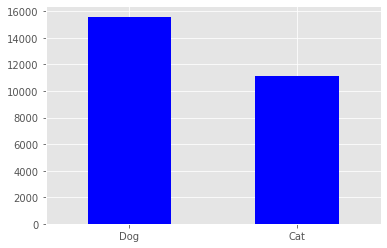

In [7]:
AnimalType = dftrain['AnimalType'].value_counts() 
AnimalType.plot(kind='bar',color='b',rot=0)

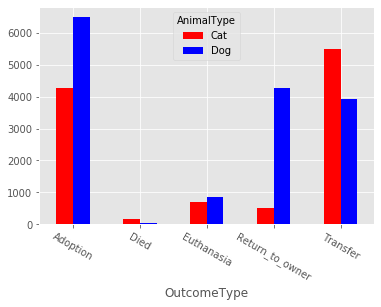

In [8]:
AnimalType = dftrain[['AnimalType','OutcomeType']].groupby(['OutcomeType','AnimalType']).size().unstack()
AnimalType.plot(kind='bar',color=['r','b'],rot=-30)

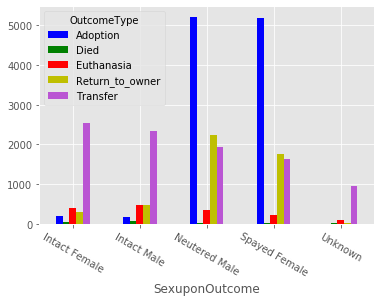

In [6]:
df = DataFrame(dftrain[['SexuponOutcome','OutcomeType']])
OutcomeSex = df.groupby(['SexuponOutcome','OutcomeType']).size().unstack()
OutcomeSex.plot(kind='bar',color=['b', 'g', 'r', 'y', '#BA55D3'],rot=-30)